# Entrenamiento Modelo Random Forest por Intervalos

**Trabajo Fin de Máster**

**Sistema de predicción para prevenir la congestión en mostradores de facturación en aeropuertos**

Autor: David Cortés Alvarez

Máster en Inteligencia Artificial

## Librerías

In [1]:
# Tratamiento de Datos
# -----------------------------------------------------------------------------------
import numpy as np
import pandas as pd

In [2]:
# Gráficos
# -----------------------------------------------------------------------------------
import matplotlib.pyplot as plt

In [3]:
# Modelos
# -----------------------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
# Varios
# -----------------------------------------------------------------------------------
import pickle

## Definición de Funciones

In [5]:
def dataPrepocessing(dataset, aeropuertos, debug=False):
    if debug: print('Datos de entrada:')
    if debug: print("")
    if debug: print('Númmero de Filas y columnas:',dataset.shape)
    if debug: print(dataset.columns)
    if debug: print("")
    if debug: print(">> Se comienza el Data Pre-Processing...")
    
    # Eliminamos aquellos registros que no son de los aeropuertos a tratar
    dataset = dataset[dataset.APD.isin(aeropuertos)]
    if debug: print("Tarea 01: Registros de vuelos filtrados por aeropuertos --> OK")
    
    # Eliminamos los que no tienen oferta u ocupación
    dataset = dataset[(dataset['OFERTA'] > 0) & (dataset['OCUPACION'] > 0)]
    if debug: print("Tarea 02: Eliminar registros sin Oferta u Ocupación --> OK")
    
    # Convertimos el identificador de vuelo a número
    dataset['VUELO'] = dataset['VUELO'].astype('str')
    dataset['VUELO'] = dataset['VUELO'].str.replace(r'^(0+)(?!$)', '', regex=True).fillna('0')
    dataset['VUELO'] = dataset['VUELO'].astype(int)
    if debug: print("Tarea 03: Conversión del número de vuelo --> OK")
    
    # Creamos una columna nueva de los minutos del día que se produce la salida del vuelo. 
    dataset.insert(9, 'SALIDA_MINUTOS_DIA', 
                   dataset.HORA.astype(str).apply(lambda x: x.split(':'))
                   .apply(lambda x: int(x[0]) * 60 + int(x[1])))
    if debug: print("Tarea 04: Creación de la columna SALIDA_MINUTOS_DIA --> OK")

    # OUTLIERS: Filtramos los registros incongruentes
    dataset = dataset[dataset['OFERTA'] >= dataset['PAX_V']]
    dataset = dataset[dataset['OFERTA'] >= dataset['PAX']]
    dataset = dataset[dataset['OFERTA'] <= dataset['CMAX']]
    if debug: print("Tarea 05: Tratamiento Outliers --> OK")
    
    # NORMALIZACIÓN y ESCALADO
    # Insertamos una nueva columna FACTOR_OFERTA basado en OFERTA a un valor ponderable entre 0-1 
    #con respecto a CCMAX 
    dataset.insert(8, 'FACTOR_OFERTA', ((dataset['OFERTA'] * 100) / dataset['CMAX'])/100)
    # Transformamos OCUPACION por FACTOR_OCUPACION
    dataset.insert(9, 'FACTOR_OCUPACION', (dataset['OCUPACION'] / 100))
    if debug: print("Tarea 06: Normalización y Escalado --> OK")
    
    # TRATAMIENTO DE NULOS
    #Borramos aquellos registros que contienen nulos en PAX, PAX_M y PAX_V
    dataset = dataset.dropna(subset=['PAX_M'])
    dataset = dataset.dropna(subset=['PAX_V'])
    dataset = dataset.dropna(subset=['FACTOR_OFERTA'])
    dataset = dataset.dropna(subset=['CMAX'])
    if debug: print("Tarea 07: Tratamiento de nulos --> OK")
    
    # Convertir los valores categóricos en numéricos
    dataset = pd.get_dummies(dataset, columns = ['APD','APA','SEGMENTO', 'FLOTA',
                                                 'PROPIETARIO_VUELO','FRANJA_HORARIA','OPERADOR',
                                                 'SECTOR','MATR'])
    if debug: print("Tarea 08: Conversión datos categóricos --> OK")
    
    # Data Cleaning 
    dataset = dataset.drop(columns=['HORA'])       # Sustitución por SALIDA_MINUTOS_DIA
    dataset = dataset.drop(columns=['OFERTA'])     # Sustitución por FACTOR_OFERTA
    dataset = dataset.drop(columns=['OCUPACION'])  # Sustitución por FACTOR_OCUPACION
    # Características no usadas en la predicción:
    dataset = dataset.drop(columns=['ID_VUELO','DIA','ANIO','CIA','FECHA_SALIDA_PROG','PAX_V'])
    if debug: print("Tarea 09: Borrado de columnas --> OK")
    if debug: print("")    
    if debug: print(">> FIN ")
    if debug: print("")
    if debug: print('Datos de salida:')
    if debug: print("")
    if debug: print('Númmero de Filas y columnas:',dataset.shape)
    if debug: print(dataset.columns)
    if debug: print("")
    
    return dataset

In [6]:
def evaluateModel(y_true, y_pred):
    print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score             :', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error                            :', metrics.max_error(y_true, y_pred))
    print('Median Absolute Error                :', metrics.median_absolute_error(y_true, y_pred))
    print('R^2                                  :', metrics.r2_score(y_true, y_pred))
    
    # Gráfica 
    plt.figure(figsize=(15,10))
    plt.scatter(y_true, y_pred, c='green')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', c='red', lw=3)
    plt.xlabel('Training Values')
    plt.ylabel('Predicted Values')
    plt.title('Training Vs Predicted')

In [7]:
def plot_history(history, key):
    plt.figure(figsize=(15,10))
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

## Carga de Datos

In [8]:
# Parámetros de entrada
Escalas_Seleccionadas = ['LPA', 'ACE', 'FUE', 'TFN', 'TFS', 'SPC', 'VDE','GMZ']
NombreFichero = "TFM_FileIN_Dataset_Training.csv"

In [9]:
#from google.colab import files
#upload = files.upload()

In [10]:
data = pd.read_csv(NombreFichero, header=0, sep=',',encoding = "ISO-8859-1")

In [11]:
# Pre-Procesado de datos
data_model=dataPrepocessing(data,Escalas_Seleccionadas,training=True,debug=True)

Datos de entrada:

Númmero de Filas y columnas: (168156, 29)
Index(['ID_VUELO', 'APD', 'APA', 'SEGMENTO', 'CIA', 'VUELO', 'FLOTA',
       'PROPIETARIO_VUELO', 'FECHA_SALIDA_PROG', 'ANIO', 'MES', 'DIA',
       'DIA_SEMANA', 'HORA', 'FESTIVO', 'MATR', 'FRANJA_HORARIA', 'OPERADOR',
       'OFERTA', 'PAX', 'OCUPACION', 'SECTOR', 'CMAX', 'PAX_V', 'PAX_M',
       'A180', 'A120', 'A60', 'A0'],
      dtype='object')

>> Se comienza el Data Pre-Processing...
Tarea 01: Registros de vuelos filtrados por aeropuertos --> OK
Tarea 02: Eliminar registros sin Oferta u Ocupación --> OK
Tarea 03: Conversión del número de vuelo --> OK
Tarea 04: Creación de la columna SALIDA_MINUTOS_DIA --> OK
Tarea 05: Tratamiento Outliers --> OK
Tarea 06: Normalización y Escalado --> OK
Tarea 07: Tratamiento de nulos --> OK
Tarea 08: Conversión datos categóricos --> OK
Tarea 09: Borrado de columnas --> OK

>> FIN 

Datos de salida:

Númmero de Filas y columnas: (146377, 116)
Index(['VUELO', 'FACTOR_OFERTA', 'FACTOR_OCUP

**Ajustes Finales**

In [12]:
col_res = ['PAX_M','A180','A120','A60','A0']
colname_predict_A120 = 'A120'
colname_predict_A60 = 'A60'
colname_predict_A0 = 'A0'

In [13]:
# División de los datos (Split)
model_columns_list = list(data_model.drop(columns=col_res,axis=1).columns.values)
X_A120 = data_model.drop(columns=col_res,axis=1).values
y_A120 = data_model[colname_predict_A120]

X_A60 = data_model.drop(columns=col_res,axis=1).values
y_A60 = data_model[colname_predict_A60]

X_A0 = data_model.drop(columns=col_res,axis=1).values
y_A0 = data_model[colname_predict_A0]

In [14]:
# Hold-out validation
X_A120_train, X_A120_test, y_A120_train, y_A120_test = train_test_split(
    X_A120, y_A120, train_size=0.7, test_size = 0.3, random_state=10)

X_A60_train, X_A60_test, y_A60_train, y_A60_test = train_test_split(
    X_A60, y_A60, train_size=0.7, test_size = 0.3, random_state=10)

X_A0_train, X_A0_test, y_A0_train, y_A0_test = train_test_split(
    X_A0, y_A0, train_size=0.7, test_size = 0.3, random_state=10)

## Random Forest Regression

In [15]:
rfm = RandomForestRegressor(
    n_estimators = 500, 
    max_features = "auto",
    bootstrap = True,
    max_depth = None,
    min_samples_leaf = 1,
    min_samples_split = 5,
    random_state=10,
    verbose=1)

### Entrenamos Modelo A120

In [16]:
rfm.fit(X_A120_train, y_A120_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.8min finished


RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=10,
                      verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.8s finished


Test score: 53.51 %

Mean Absolute Error (MAE)            : 3.0311501455452334
Mean Squared Error (MSE)             : 21.68487455055073
Root Mean Squared Error (RMSE)       : 4.656702110995584
Mean Absolute Percentage Error (MAPE): 1526001131165489.5
Explained Variance Score             : 0.5352640750064372
Max Error                            : 50.362082994782995
Median Absolute Error                : 1.9227079365079347
R^2                                  : 0.5351232954264643


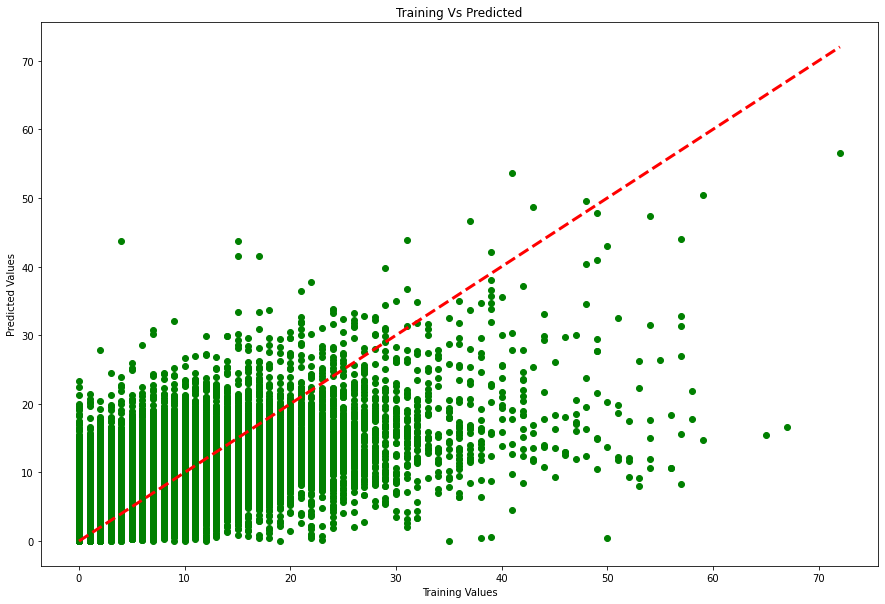

In [17]:
# Predicción de los datos de test
y_A120_pred_rf=rfm.predict(X_A120_test)

# Model Score
print("Test score: {0:.2f} %".format(100 * rfm.score(X_A120_test, y_A120_test)))
print("")

# Model Evaluation
evaluateModel(y_A120_test,y_A120_pred_rf)

In [18]:
# Model Score
print("Test score: {0:.2f} %".format(100 * rfm.score(X_A120_test, y_A120_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 53.51 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.8s finished


Mean Absolute Error (MAE)            : 3.0311501455452334
Mean Squared Error (MSE)             : 21.68487455055073
Root Mean Squared Error (RMSE)       : 4.656702110995584
Mean Absolute Percentage Error (MAPE): 1526001131165489.5
Explained Variance Score             : 0.5352640750064372
Max Error                            : 50.362082994782995
Median Absolute Error                : 1.9227079365079347
R^2                                  : 0.5351232954264643


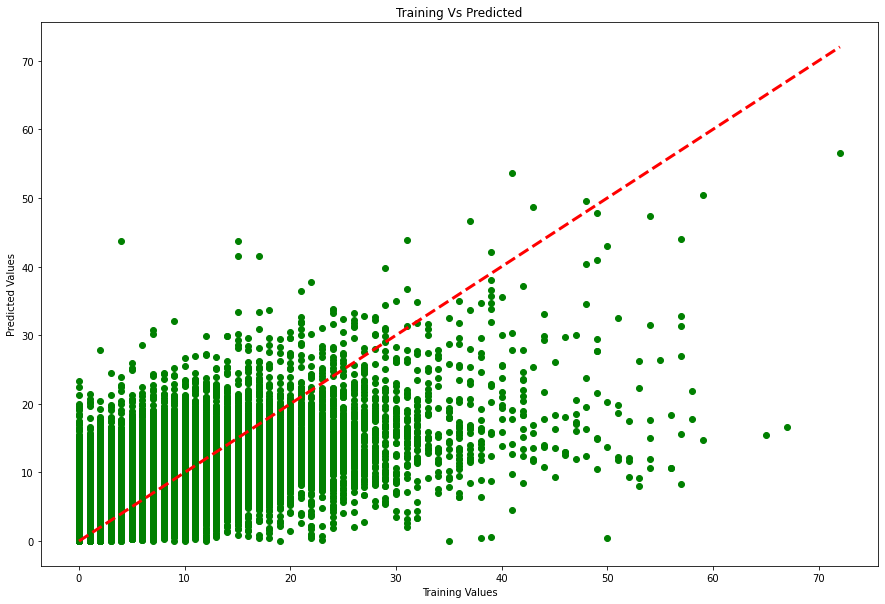

In [19]:
# Model Evaluation
evaluateModel(y_A120_test,y_A120_pred_rf)

Grabamos modelo de Random Forest para A120: 

In [20]:
# Save the Modle to file in the current working directory
rfm.feature_names = model_columns_list
with open("TFM_FileOUT_ModeloRF_A120.pkl", 'wb') as file:  
    pickle.dump(rfm, file)

### Entrenamos Modelo A60

In [21]:
rfm.fit(X_A60_train, y_A60_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.7min finished


RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=10,
                      verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.0s finished


Test score: 43.46 %

Mean Absolute Error (MAE)            : 3.958667106866157
Mean Squared Error (MSE)             : 29.65785474689419
Root Mean Squared Error (RMSE)       : 5.445902564946805
Mean Absolute Percentage Error (MAPE): 691246773184241.9
Explained Variance Score             : 0.4346283727240706
Max Error                            : 62.88357022422022
Median Absolute Error                : 3.018763275613278
R^2                                  : 0.43462765811665716


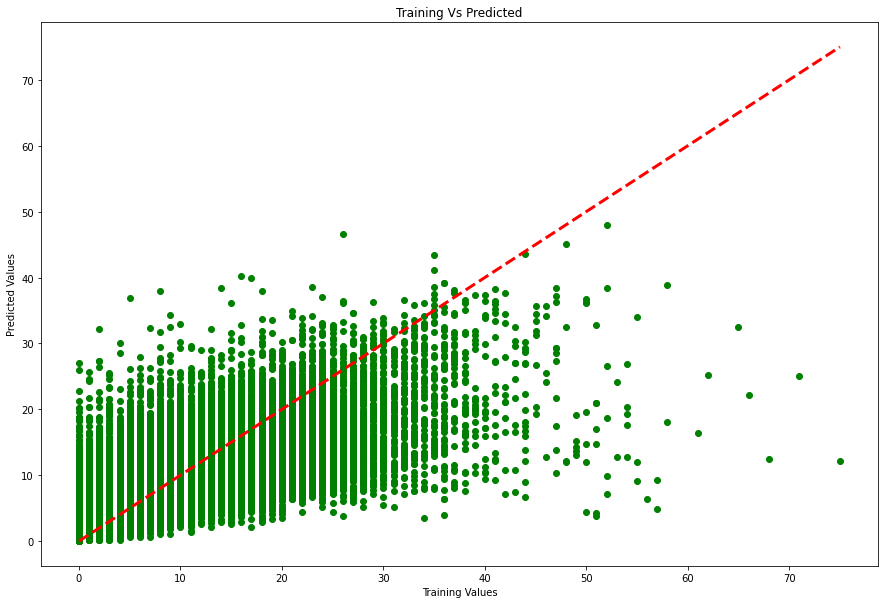

In [22]:
# Predicción de los datos de test
y_A60_pred_rf=rfm.predict(X_A60_test)

# Model Score
print("Test score: {0:.2f} %".format(100 * rfm.score(X_A60_test, y_A60_test)))
print("")

# Model Evaluation
evaluateModel(y_A60_test,y_A60_pred_rf)

Grabamos modelo de Random Forest para A60: 

In [23]:
# Save the Modle to file in the current working directory
rfm.feature_names = model_columns_list
with open("TFM_DCA_ModeloRF_A60.pkl", 'wb') as file:  
    pickle.dump(rfm, file)

### Entrenamos Modelo A0

In [24]:
rfm.fit(X_A0_train, y_A0_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.3min finished


RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=10,
                      verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.9s finished


Test score: 69.29 %

Mean Absolute Error (MAE)            : 2.025768721768917
Mean Squared Error (MSE)             : 14.60249188598709
Root Mean Squared Error (RMSE)       : 3.8213206991807285
Mean Absolute Percentage Error (MAPE): 1381999597618373.8
Explained Variance Score             : 0.693066314172045
Max Error                            : 61.67720317460317
Median Absolute Error                : 0.6076551587301589
R^2                                  : 0.6929333204391348


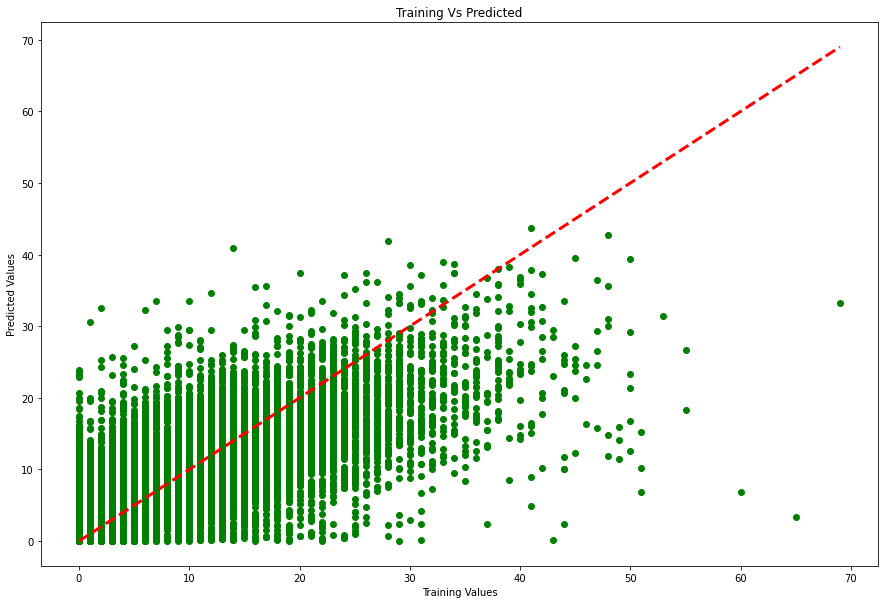

In [25]:
# Predicción de los datos de test
y_A0_pred_rf=rfm.predict(X_A0_test)

# Model Score
print("Test score: {0:.2f} %".format(100 * rfm.score(X_A0_test, y_A0_test)))
print("")

# Model Evaluation
evaluateModel(y_A0_test,y_A0_pred_rf)

Grabamos modelo de Random Forest para A60: 

In [26]:
# Save the Modle to file in the current working directory
rfm.feature_names = model_columns_list
with open("TFM_DCA_ModeloRF_A0.pkl", 'wb') as file:  
    pickle.dump(rfm, file)

### Test Modelos A120, A60 y A0

Testeamos volviendo a cargar los modelos: 

In [27]:
# Load the Model back from file
with open("TFM_FileOUT_ModeloRF_A120.pkl", 'rb') as file:  
    ModeloRF_A120 = pickle.load(file)
print("Test score: {0:.2f} %".format(100 * ModeloRF_A120.score(X_A120_test, y_A120_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 53.51 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.7s finished


In [28]:
# Load the Model back from file
with open("TFM_FileOUT_ModeloRF_A60.pkl", 'rb') as file:  
    ModeloRF_A60 = pickle.load(file)
print("Test score: {0:.2f} %".format(100 * ModeloRF_A60.score(X_A60_test, y_A60_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 43.46 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.9s finished


In [29]:
# Load the Model back from file
with open("TFM_FileOUT_ModeloRF_A0.pkl", 'rb') as file:  
    ModeloRF_A0 = pickle.load(file)
print("Test score: {0:.2f} %".format(100 * ModeloRF_A0.score(X_A0_test, y_A0_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 69.29 %


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.1s finished
